In [11]:
import pandas as pd
from media_processing_lib.collage_maker import collage_fn
from media_processing_lib.image import image_add_title, image_write, image_read, image_resize, image_add_text
import numpy as np
from pathlib import Path
from natsort import natsorted
from typing import List

import sys
sys.path.append(Path.cwd().parent.__str__())
from main import get_output_nodes

#/scratch/nvme0n1/ngc/ngc-single-links/nodes/nasa/nasa_nodes.py
sys.path.append("/scratch/nvme0n1/ngc/ngclib/nodes_repository/nasa")
from nasa_nodes import _act_to_cmap as act_to_cmap

import matplotlib.pyplot as plt
from media_processing_lib.video import MPLVideo
from simple_caching import cache_fn
from simple_caching.storage import DictMemory

In [12]:
it1_dir = Path("../dump_dirs/nasa/iterative_training/dump_dir_it1_test/").absolute()
it3_dir_lr = Path("/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it3_lr_test").absolute()
it3_dir = Path("/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it3_nn_test").absolute()
assert it1_dir.exists() and it3_dir.exists()
cmap_dir = Path("/scratch/nvme0n1/ngc/ngclib/nodes_repository/nasa/cmaps")

out_nodes = get_output_nodes(it1_dir)
print(f"Out nodes: {out_nodes}")

cmap_files = {"AOD": cmap_dir / "AerosolOpticalDepth.act", "CarbonMonoxide": cmap_dir / "CarbonMonoxide.act",
         "FIRE": cmap_dir / "Fire.act", "LAI": cmap_dir / "LeafAreaIndex.act", "LSTD_AN": cmap_dir / "TemperatureAnomaly.act",
         "LSTN_AN": cmap_dir / "TemperatureAnomaly.act", "WV": cmap_dir / "WaterVapor.act"}
cmaps = {node: act_to_cmap(cmap_files[node].__str__()) for node in out_nodes}


Out nodes: ['AOD', 'CarbonMonoxide', 'FIRE', 'LAI', 'LSTD_AN', 'LSTN_AN', 'WV']


In [13]:

def plot_fn(cmap, x, gt = None):
    y = np.clip(x, 0, 1)
    if gt is not None:
        mask = (gt != 0)
        y = y * mask
    y = y * 255
    y[y==0] = 255
    y = y.astype(np.uint).squeeze()
    y_rgb = cmap[y]
    return pad(y_rgb)

def pad(x):
    return np.pad(x, [(0, 0), (0, 10), (0, 0)])

def red_vs_green(y1, y2, gt, tol=None):
    res = np.zeros((*gt.shape[0:2], 3), dtype=np.uint8)
    where_better = np.abs(y1 - gt) - np.abs(y2 - gt)
    where_better = where_better[..., 0]
    if tol is not None:
        where_better[(where_better > -tol) & (where_better < tol)] = 0
    where_better = np.sign(where_better)
    res[np.where(where_better == 1)] = (0, 255, 0)
    res[np.where(where_better == -1)] = (255, 0, 0)
    res = res * (gt != 0)
    return res

def npy_from_dir(res_dir: Path, n: int = None, seed: int=42) -> List[Path]:
    assert res_dir.exists(), res_dir
    res = np.array(natsorted([x for x in res_dir.glob("*.npz")], key=lambda p: p.name))
    if n is not None:
        np.random.seed(seed)
        ix = np.random.choice(len(res), n, replace=False)
        res = res[ix]
    return res

# Compute consistency between -k/+k neighboring frames
def compute_consistency(y_vol: np.ndarray, k:int):
    timespan = y_vol.shape[0]
    consistency_array = []
    for index in range(timespan):
        start_idx = max(0, index - k)
        end_idx = min(timespan, index + k + 1)

        cons_map = np.std(y_vol[start_idx:end_idx], axis=0)
        # cons_value = np.mean(cons_map)
        consistency_array.append(cons_map)

    assert(len(consistency_array) == timespan)

    res = np.array(consistency_array)
    print(res.shape)
    return res

def red_vs_green_cons(y1, y2, gt, tol=None):
    res = np.zeros((*gt.shape[0:2], 3), dtype=np.uint8)
    where_better = np.sign(y1 - y2)[..., 0]
    res[np.where(where_better == 1)] = (0, 255, 0)
    res[np.where(where_better == -1)] = (255, 0, 0)
    res = res * (gt != 0)
    return res


LSTN_AN
(30, 540, 1080, 1)
(30, 540, 1080, 1)
AOD (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
CarbonMonoxide (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
FIRE (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LAI (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LSTD_AN (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LSTN_AN (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
WV (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)


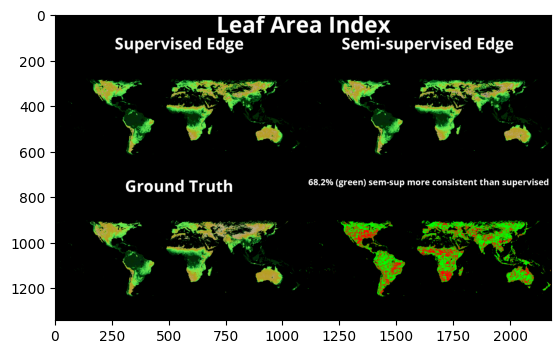

In [16]:
def do_one_node(node, it1_dir, itn_dir, N: int=None):
    best_performing_edge = pd.read_csv(it1_dir / f"{node}_results_edges_test.csv")
    best_performing_edge = best_performing_edge[best_performing_edge["edges"].str.startswith("Single")].iloc[0]["edges"]
    gt_dir = it1_dir / node / "gt/state/npy"
    it1_edge_dir = it1_dir / node / "0"/ best_performing_edge / "npy"
    itn_edge_dir = itn_dir / node / "0" / best_performing_edge / "npy"
    assert it1_edge_dir.exists() and itn_edge_dir.exists() and gt_dir.exists()

    seed = np.random.randint(1000)
    gt_files = npy_from_dir(gt_dir, N, seed)
    it1_edge_file_paths = npy_from_dir(it1_edge_dir, N, seed)
    itn_edge_file_paths = npy_from_dir(itn_edge_dir, N, seed)

    gt_raw = np.array([np.load(x)["arr_0"] for x in gt_files])
    y_it1_raw = np.array([np.load(x)["arr_0"] for x in it1_edge_file_paths])
    y_itn_raw = np.array([np.load(x)["arr_0"] for x in itn_edge_file_paths])
    cons_it1 = compute_consistency(y_it1_raw, k=3)
    cons_itn = compute_consistency(y_itn_raw, k=3)

    gt_img = np.array([plot_fn(cmaps[node], x) for x in gt_raw])
    y_it1_img = np.array([plot_fn(cmaps[node], x, _gt) for x, _gt in zip(y_it1_raw, gt_raw)])
    y_itn_img = np.array([plot_fn(cmaps[node], x, _gt) for x, _gt in zip(y_itn_raw, gt_raw)])

    rg_img = np.array([red_vs_green_cons(y1, y2, gt, tol=0) for y1, y2, gt in zip(cons_it1, cons_itn, gt_raw)])
    return y_it1_img, y_itn_img, gt_img, rg_img

def make_stacks(nodes_data, outro_frames:int = 10):
    stacked = []
    all_scores = []
    for node, (y_it1_img, y_itn_img, gt_img, rg_img) in nodes_data.items():
        scores = rg_img.sum(1).sum(1)[:, 0:2]
        print(node, y_it1_img.shape, y_itn_img.shape, gt_img.shape, rg_img.shape)
        # scores_per_frame = scores / scores.sum(1)[:, None]
        # print(node, scores.sum(0))
        all_scores.append(scores.sum(0).tolist())
        scores_overall = scores.sum(0) / scores.sum(0).sum()

        for i, (y1, y2, gt, rg) in enumerate(zip(y_it1_img, y_itn_img, gt_img, rg_img)):
            gt = image_add_title(gt, "Ground Truth", size_px=60)
            y1 = image_add_title(y1, "Supervised Edge", size_px=60)
            y2 = image_add_title(y2, "Semi-supervised Edge", size_px=60)
            rg = image_add_title(rg, f"{scores_overall[1]*100:.1f}% (green) sem-sup more consistent than supervised", size_px=37, font_color="white")
            # rg = image_add_title(rg, f"{scores_overall[0]*100:.1f}% supervised                                              ", size_px=45, font_color="red")
            # rg = image_add_text(rg, text=f" - ", position=(-15, 460), font_color="white", font_size_px=45)
            # rg = image_add_text(rg, text=f"{scores_overall[1]*100:.1f}% semi-supervised", position=(-15, 500), font_color="green", font_size_px=45)
            rg = np.pad(rg, [(0, 0), (10, 0), (0, 0)])
            stack = collage_fn([y1, y2, gt, rg])
            nodes = {
                "AOD": "Aerosol Optical Depth",
                "CarbonMonoxide": "Carbon Monoxide",
                "FIRE": "Fire",
                "LAI": "Leaf Area Index",
                "LSTD_AN": "Land Surface Temperature Anomaly (day)",
                "LSTN_AN": "Land Surface Temperature Anomaly (night)",
                "WV": "Water Vapor",
            }
            stack = image_add_title(stack, nodes[node], size_px=80, top_padding=100)
            stacked.append(stack)

    # print( "sup vs semisup per node", np.array(all_scores).sum(0), "\n", np.array(all_scores))
    all_scores = np.array(all_scores).sum(0) / np.array(all_scores).sum(0).sum()
    text = f"Semi-supervised is better on {all_scores[1]*100:.2f}% \n        of all pixels across all nodes"
    outro = image_add_text(stack * 0, text=text, position=(600, 400), font_size_px=60, font_color="white")
    for _ in range(outro_frames):
        stacked.append(outro)

    stacked = np.array(stacked)
    return stacked



In [32]:
nodes_data = {}
N = None
# for node in ["LSTN_AN"]:
for node in out_nodes:
    print(node)
    _it3 = it3_dir_lr if node in ["LSTD_AN", "CarbonMonoxide"] else it3_dir
    _it1 = it1_dir if node != "LSTN_AN" else it3_dir_lr
    nodes_data[node] = do_one_node(node, _it1, _it3, N)

outro_frames=10
res = make_stacks(nodes_data, outro_frames=outro_frames)
# if N > 1:
plt.imshow(res[np.random.randint(len(res)-outro_frames)])
# plt.imshow(res[11])
plt.figure()
plt.imshow(res[-1])

AOD
(30, 540, 1080, 1)
(30, 540, 1080, 1)
CarbonMonoxide
(30, 540, 1080, 1)
(30, 540, 1080, 1)
FIRE
(30, 540, 1080, 1)
(30, 540, 1080, 1)
LAI
(30, 540, 1080, 1)
(30, 540, 1080, 1)
LSTD_AN
(30, 540, 1080, 1)
(30, 540, 1080, 1)
LSTN_AN
(30, 540, 1080, 1)
(30, 540, 1080, 1)
WV
(30, 540, 1080, 1)
(30, 540, 1080, 1)
AOD (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
CarbonMonoxide (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
FIRE (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LAI (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LSTD_AN (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
LSTN_AN (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)
WV (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1090, 3) (30, 540, 1080, 3)


In [33]:
video = MPLVideo(res, fps=3)
print(video)
video.write("video.mp4")

[MPL Video]
-  Frame: (1342, 2180).
-  Duration: 220.
-  FPS: 3.00.


[ImageIO::video_write]:   0%|          | 0/220 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2180, 1342) to (2192, 1344) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x6c14900] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x6c30c40] Warning: data is not aligned! This can lead to a speed loss
[ImageIO::video_write]: 100%|██████████| 220/220 [00:05<00:00, 42.52it/s]
